# Train Tree Based Models

#### Outline
   
- **Train and evaluate Models with best params found by the optimization algorithm**
    - XGBOOST
    - LightGBM
    - Random Forest
    
- **Save trained models**

In [1]:
import os
import sys
import inspect
import pathlib

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
ROOTDIR = os.path.dirname(currentdir)
print('ROOTDIR', ROOTDIR)
sys.path.insert(0,ROOTDIR)

import json
import numpy  as np
import os 
import pandas as pd
import random

from scripts.preprocess import get_feature_list_from_text_excluding_target
from scripts.utils import read_json_file
from scripts.model import get_model, get_prediction, save_model, load_saved_model
from scripts.evaluate import get_evaluation_report
from scripts.visualization import precision_recall_curve_comparison
from scripts.visualization import plot_confusion_matrix
from scripts.utils import set_seed
from xgboost import plot_importance

seed = 112358

set_seed(seed)

results = {}

ROOTDIR E:\github_projects\Case-Study-Campaign-Optimization


## Data

In [2]:
full_data = pd.read_csv(fr"{ROOTDIR}/data/prepared_data_for_modeling.csv")
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23485 entries, 0 to 23484
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   datetime                    23485 non-null  object 
 1   campaign_id                 23485 non-null  int64  
 2   spend                       23485 non-null  float64
 3   impressions                 23485 non-null  float64
 4   clicks                      23485 non-null  float64
 5   purchase                    23485 non-null  float64
 6   hour                        23485 non-null  int64  
 7   unique_ids                  23485 non-null  object 
 8   first_24_hour               23485 non-null  bool   
 9   test_set                    23485 non-null  bool   
 10  ctr                         23485 non-null  float64
 11  conversion_rate             23485 non-null  float64
 12  custom_conversion_rate      23485 non-null  float64
 13  good_performance            234

Specify target variable and get features

In [3]:
target = 'next_hour_good_performance'
sample_features = get_feature_list_from_text_excluding_target(fr"{ROOTDIR}/data/feature_lists_for_modeling.txt" , 
                                                              target)

Successfully returned list from:  E:\github_projects\Case-Study-Campaign-Optimization/data/feature_lists_for_modeling.txt


In [4]:
sample_features

['spend',
 'purchase',
 'impressions',
 'hour',
 'good_performance',
 'dayofweek',
 'custom_conversion_rate',
 'conversion_rate',
 'clicks',
 'campaign_id']

Get Train/Test Split

In [5]:
training_data = full_data[full_data['first_24_hour']][sample_features+[target]]
X_train = np.ascontiguousarray(training_data[sample_features])
y_train = np.ascontiguousarray(training_data[target])

test_data = full_data[full_data['test_set']][sample_features+[target]]
X_test = np.ascontiguousarray(test_data[sample_features])
y_test = np.ascontiguousarray(test_data[target])

del training_data, test_data

### XGBoost

Load best params found

In [6]:
best_params = read_json_file(fr"{ROOTDIR}/HPO/XGB/best_params.json")
best_params

{'colsample_bylevel': 0.8015579071911014,
 'colsample_bytree': 0.44364889457651413,
 'gamma': 3.811128976537413e-05,
 'learning_rate': 0.2700390206185342,
 'max_delta_step': 18,
 'max_depth': 36,
 'min_child_weight': 4,
 'n_estimators': 83,
 'reg_alpha': 1.5057560255472018e-06,
 'reg_lambda': 659.4262286994368,
 'scale_pos_weight': 26,
 'subsample': 0.8835665823899177}

##### Train Model

In [15]:
xgb_model = get_model(name='xgboost',
                         colsample_bylevel= best_params['colsample_bylevel'],
                          colsample_bytree= best_params['colsample_bytree'], 
                          gamma= best_params['gamma'],
                          learning_rate= best_params['learning_rate'],
                          max_delta_step= best_params['max_delta_step'], 
                          max_depth= best_params['max_depth'],
                          min_child_weight= best_params['min_child_weight'],
                          n_estimators= best_params['n_estimators'],
                          reg_alpha= best_params['reg_alpha'], 
                          reg_lambda= best_params['reg_lambda'],
                          scale_pos_weight= best_params['scale_pos_weight'],
                          subsample= best_params['subsample'],
                          random_state=seed)

xgb_model.fit(X_train, y_train)
print('\n\nModel trained successfully!')

[16:53:54] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Model trained successfully!


#### Evaluate Model

On Test Set

PR-curve threshold=0.837545, F-Score=0.372


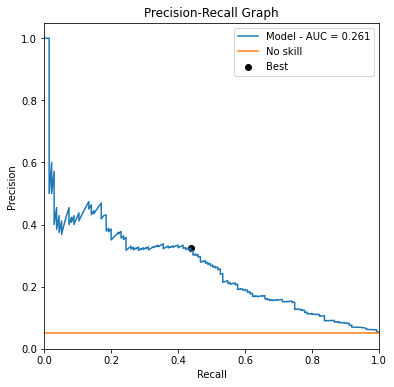

Threshold=0.837, Best macro F1-Score=0.66578

               precision    recall  f1-score   support

     Bad Ads       0.97      0.95      0.96      2470
    Good Ads       0.32      0.44      0.37       135

    accuracy                           0.92      2605
   macro avg       0.65      0.69      0.67      2605
weighted avg       0.94      0.92      0.93      2605

Matthews correlation coefficient:  0.33673059100889113


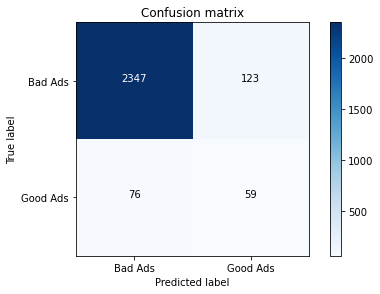

In [7]:
save_path = fr"{ROOTDIR}\\plots\\XGB\\"

preidiction = get_prediction(xgb_model, X_test)

labels = ['Bad Ads', 'Good Ads']
report = get_evaluation_report(y_test, 
                               preidiction, 
                               labels, 
                               plot='precision-recall', 
                               save_path=save_path+'test')

results['xgb'] = [report['auc'],\
                  report['classification_report']['macro avg']['precision'],\
                  report['classification_report']['macro avg']['recall'],\
                  report['classification_report']['macro avg']['f1-score'],\
                  report['mcc']]

On Training set

PR-curve threshold=0.823544, F-Score=0.388


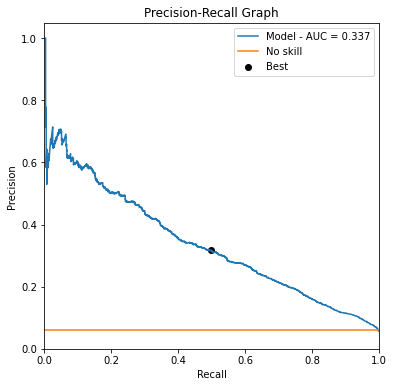


               precision    recall  f1-score   support

     Bad Ads       0.97      0.94      0.96     19701
    Good Ads       0.33      0.46      0.38      1179

    accuracy                           0.92     20880
   macro avg       0.65      0.70      0.67     20880
weighted avg       0.93      0.92      0.92     20880

Matthews correlation coefficient:  0.3449957436204355


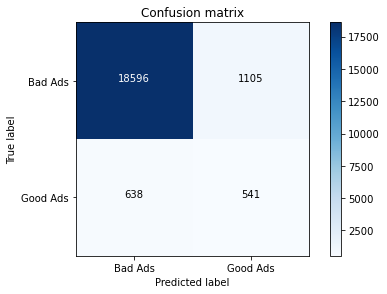

In [8]:
preidiction = get_prediction(xgb_model, X_train)
report = get_evaluation_report(y_train, 
                               preidiction, 
                               labels, 
                               threshold = report['threshold'], 
                               plot='precision-recall',
                               save_path=save_path+'train')

#### Save Model

In [24]:
path = fr"{ROOTDIR}/model"
model_name = 'xgb_model'
save_model(xgb_model, path, model_name)

xgb_model.pickle.dat saved in : E:\Data Science Masters\university\coding challenge\future_demand/model


## b. LightGBM

Load best params found

In [10]:
best_params = read_json_file(fr"{ROOTDIR}/HPO/LightGBM/best_params.json")
best_params

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.4194735998017874,
 'learning_rate': 0.3713670265402593,
 'max_bin': 4761,
 'max_depth': 19,
 'n_estimators': 60,
 'num_leaves': 2000,
 'reg_alpha': 1.0,
 'reg_lambda': 1000.0,
 'scale_pos_weight': 32,
 'subsample': 0.7029212166466253}

#### Train Model

In [11]:
lgb_model  = get_model(name='lightgbm',
                       colsample_bytree = best_params['colsample_bytree'], 
                       learning_rate = best_params['learning_rate'], 
                       max_depth = best_params['max_depth'], 
                       n_estimators = best_params['n_estimators'], 
                       reg_alpha = best_params['reg_alpha'], 
                       reg_lambda = best_params['reg_lambda'],
                       scale_pos_weight  = best_params['scale_pos_weight'], 
                       boosting_type = best_params['boosting_type'], 
                       subsample = best_params['subsample'], 
                       num_leaves = best_params['num_leaves'],
                       random_state=seed)

lgb_model.fit(X_train, y_train)
print('\n\nModel trained successfully!')



Model trained successfully!


#### Evaluate Model

On Test Set

PR-curve threshold=0.853550, F-Score=0.358


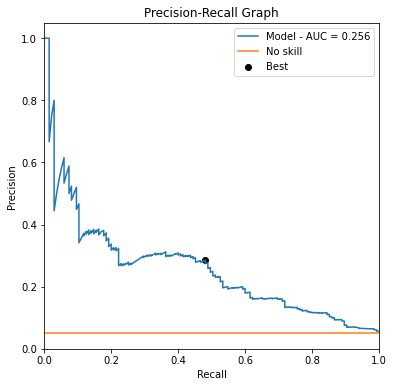

Threshold=0.865, Best macro F1-Score=0.65642

               precision    recall  f1-score   support

     Bad Ads       0.97      0.94      0.96      2470
    Good Ads       0.30      0.44      0.36       135

    accuracy                           0.92      2605
   macro avg       0.63      0.69      0.66      2605
weighted avg       0.93      0.92      0.93      2605

Matthews correlation coefficient:  0.3206600069072024


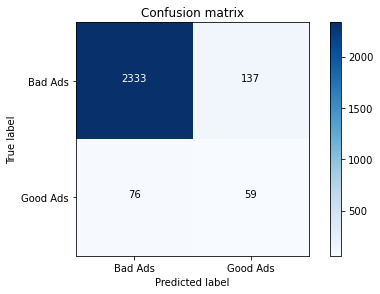

In [12]:
save_path = fr"{ROOTDIR}\\plots\\LightGBM\\"

preidiction = get_prediction(lgb_model, X_test)
labels = ['Bad Ads', 'Good Ads']
report = get_evaluation_report(y_test, 
                               preidiction, 
                               labels, 
                               plot='precision-recall',
                               save_path = save_path+'test')

results['lightgbm'] = [report['auc'],\
                  report['classification_report']['macro avg']['precision'],\
                  report['classification_report']['macro avg']['recall'],\
                  report['classification_report']['macro avg']['f1-score'],\
                  report['mcc']]

On Training Set

PR-curve threshold=0.847077, F-Score=0.374


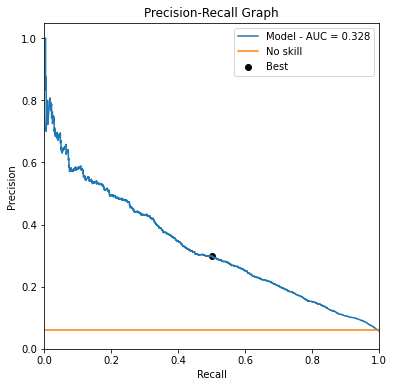


               precision    recall  f1-score   support

     Bad Ads       0.97      0.94      0.95     19701
    Good Ads       0.31      0.44      0.37      1179

    accuracy                           0.91     20880
   macro avg       0.64      0.69      0.66     20880
weighted avg       0.93      0.91      0.92     20880

Matthews correlation coefficient:  0.328182664432074


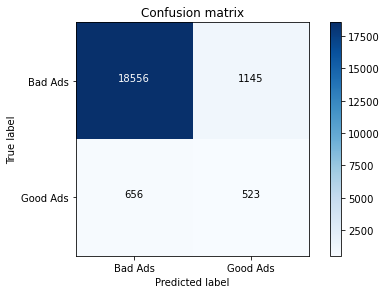

In [13]:
preidiction = get_prediction(lgb_model, X_train)
report = get_evaluation_report(y_train, 
                               preidiction, 
                               labels, 
                               threshold = report['threshold'], 
                               plot='precision-recall',
                               save_path = save_path+'train')

#### Save Model

In [23]:
path = fr"{ROOTDIR}/model"
model_name = 'lightGBM_model'
save_model(lgb_model, path, model_name)

lightGBM_model.pickle.dat saved in : E:\Data Science Masters\university\coding challenge\future_demand/model


## c. Random Forest

Load best params found

In [12]:
best_params = read_json_file(fr"{ROOTDIR}/HPO/RandomForest/best_params.json")
best_params

{'class_weight': 'balanced_subsample',
 'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_split': 9,
 'n_estimators': 1000}

In [ ]:
rf_model = get_model( name ='randomforest',
                n_estimators = best_params['n_estimators'], 
                max_depth = best_params['max_depth'],
                max_features = best_params['max_features'],
                min_samples_split=best_params['min_samples_split'], 
                class_weight = best_params['class_weight'],
                criterion= best_params['criterion'],
                random_state=seed
                )

rf_model.fit(X_train, y_train)

print('\n\nModel trained successfully!')

#### Train Model

In [16]:
rf_model = get_model( name ='randomforest',
                n_estimators = best_params['n_estimators'], 
                max_depth = best_params['max_depth'],
                max_features = best_params['max_features'],
                min_samples_split=best_params['min_samples_split'], 
                class_weight = best_params['class_weight'],
                criterion= best_params['criterion'],
                random_state=seed
                )

rf_model.fit(X_train, y_train)

print('\n\nModel trained successfully!')



Model trained successfully!


#### Evaluate Model

On Test Set

PR-curve threshold=0.719647, F-Score=0.324


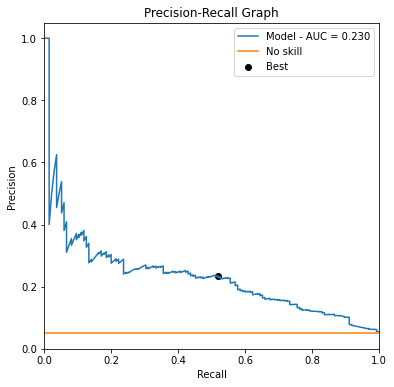

Threshold=0.733, Best macro F1-Score=0.63212

               precision    recall  f1-score   support

     Bad Ads       0.97      0.93      0.95      2470
    Good Ads       0.25      0.43      0.32       135

    accuracy                           0.90      2605
   macro avg       0.61      0.68      0.63      2605
weighted avg       0.93      0.90      0.92      2605

Matthews correlation coefficient:  0.27953733929102775


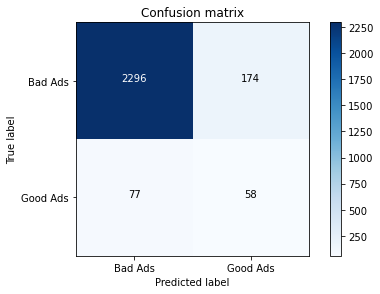

In [17]:
save_path = fr"{ROOTDIR}\\plots\\RandomForest\\"
preidiction = get_prediction(rf_model, X_test)

labels = ['Bad Ads', 'Good Ads']
report = get_evaluation_report(y_test, 
                               preidiction, 
                               labels, plot='precision-recall', 
                               save_path=save_path+'train')

results['randomforest'] = [report['auc'],\
                  report['classification_report']['macro avg']['precision'],\
                  report['classification_report']['macro avg']['recall'],\
                  report['classification_report']['macro avg']['f1-score'],\
                  report['mcc']]

On Training Set

PR-curve threshold=0.737545, F-Score=0.338


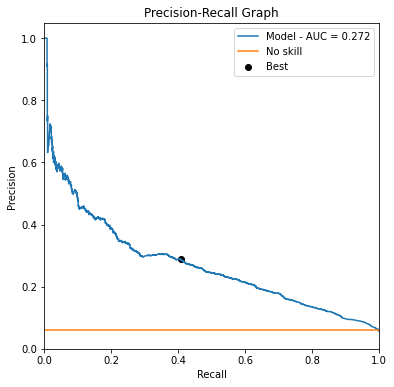


               precision    recall  f1-score   support

     Bad Ads       0.96      0.93      0.95     19701
    Good Ads       0.28      0.42      0.33      1179

    accuracy                           0.90     20880
   macro avg       0.62      0.68      0.64     20880
weighted avg       0.93      0.90      0.91     20880

Matthews correlation coefficient:  0.29226227451900194


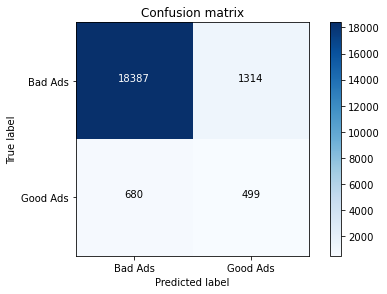

In [18]:
preidiction = get_prediction(rf_model, X_train)
report = get_evaluation_report(y_train, 
                               preidiction, 
                               labels, 
                               threshold = report['threshold'], 
                               plot='precision-recall',
                               save_path=save_path+'train')

#### Save Model

In [22]:
path = fr"{ROOTDIR}/model"
model_name = 'rf_model'
save_model(rf_model, path, model_name)

rf_model.pickle.dat saved in : E:\Data Science Masters\university\coding challenge\future_demand/model


#### Save Results in a csv

In [21]:
results_df = pd.DataFrame.from_dict(results).T
results_df.columns = ['pr_auc', 'macro_precision', 'macro_recall', 'macro_f1', 'mcc']
results_df.to_csv(fr"{ROOTDIR}/results/model_results.csv")
results_df

,pr_auc,macro_precision,macro_recall,macro_f1,mcc
xgb,0.261456,0.646405,0.693620,0.665785,0.336731
lightgbm,0.255616,0.634736,0.690786,0.656419,0.320660
randomforest,0.230132,0.608776,0.679592,0.632124,0.279537
